## Class test: Metropolis Algorithm (Two Coin Toss))

In [2]:
# Metropolis Algorithm
# algorithm applied to two parameters called theta1,theta2 defined on the 
# domain [0,1]x[0,1].

# Load the MASS package, which defines the mvrnorm function.
# If this "library" command balks, you must intall the MASS package:
#install.packages("MASS")
library(MASS)

# Define the likelihood function.
# The input argument is a vector: theta = c( theta1 , theta2 )
likelihood = function( theta ) {
	# Data are constants, specified here:
	z1 = 32 ; N1 = 100 ; z2 = 70 ; N2 = 100
	likelihood = ( theta[1]^z1 * (1-theta[1])^(N1-z1)
                 * theta[2]^z2 * (1-theta[2])^(N2-z2) )
	return( likelihood )
}

# Define the prior density function.
# The input argument is a vector: theta = c( theta1 , theta2 )
prior = function( theta ) {
	# Here's a beta-beta prior:
	a1 = 3 ; b1 = 3 ; a2 = 3 ; b2 = 3
	prior = dbeta( theta[1] , a1 , b1) * dbeta( theta[2] , a2 , b2) 
	return( prior )
}

# Define the relative probability of the target distribution, as a function 
# of theta.  The input argument is a vector: theta = c( theta1 , theta2 ). 
# For our purposes, the value returned is the UNnormalized posterior prob.
targetRelProb = function( theta ) {
	if ( all( theta >= 0.0 ) & all( theta <= 1.0 ) ) {
		targetRelProbVal =  likelihood( theta ) * prior( theta )
	} else {
		# This part is important so that the Metropolis algorithm
		# never accepts a jump to an invalid parameter value.
		targetRelProbVal = 0.0
	}
	return( targetRelProbVal )
}

# Specify the length of the trajectory, i.e., the number of jumps to try.
trajLength = ceiling( 10000 / .9 ) # arbitrary large number
# Initialize the vector that will store the results.
trajectory = matrix( 0 , nrow=trajLength , ncol=2 )
# Specify where to start the trajectory
trajectory[1,] = c( 0.50 , 0.50 ) # arbitrary start values of the two param's
# Specify the burn-in period.
burnIn = ceiling( .1 * trajLength ) # arbitrary number
# Initialize accepted, rejected counters, just to monitor performance.
nAccepted = 0
nRejected = 0
# Specify the seed, so the trajectory can be reproduced.
set.seed(47405)
# Specify the covariance matrix for multivariate normal proposal distribution.
nDim = 2 ; sd1 = 0.2 ; sd2 = 0.2
covarMat = matrix( c( sd1^2 , 0.00 , 0.00 , sd2^2 ) , nrow=nDim , ncol=nDim )

# Now generate the random walk. stepIdx is the step in the walk.
for ( stepIdx in 1:(trajLength-1) ) {
	currentPosition = trajectory[stepIdx,]
	# Use the proposal distribution to generate a proposed jump.
	# The shape and variance of the proposal distribution can be changed
	# to whatever you think is appropriate for the target distribution.
	proposedJump = mvrnorm( n=1 , mu=rep(0,nDim), Sigma=covarMat )
	# Compute the probability of accepting the proposed jump.
	probAccept = min( 1,
		targetRelProb( currentPosition + proposedJump )
		/ targetRelProb( currentPosition ) )
	# Generate a random uniform value from the interval [0,1] to
	# decide whether or not to accept the proposed jump.
	if ( runif(1) < probAccept ) {
		# accept the proposed jump
		trajectory[ stepIdx+1 , ] = currentPosition + proposedJump
		# increment the accepted counter, just to monitor performance
		if ( stepIdx > burnIn ) { nAccepted = nAccepted + 1 }
	} else {
		# reject the proposed jump, stay at current position
		trajectory[ stepIdx+1 , ] = currentPosition
		# increment the rejected counter, just to monitor performance
		if ( stepIdx > burnIn ) { nRejected = nRejected + 1 }
	}
}

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Begin making inferences by using the sample generated by the
# Metropolis algorithm.

# Extract just the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : dim(trajectory)[1] , ]

# Compute the mean of the accepted points.
meanTraj =  apply( acceptedTraj , 2 , mean )
# Compute the standard deviations of the accepted points.
sdTraj = apply( acceptedTraj , 2 , sd )

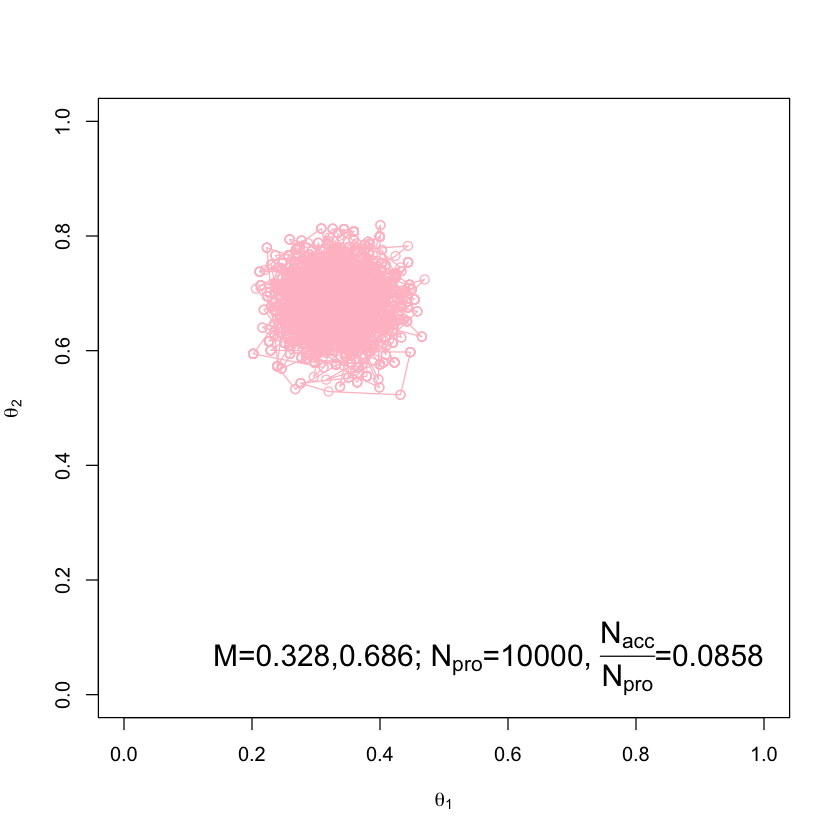

In [9]:
# Display the sampled points



plot( acceptedTraj , type = "o" , xlim = c(0,1) , xlab = bquote(theta[1]) ,
      ylim = c(0,1) , ylab = bquote(theta[2]) , col="pink" )

# Display means and rejected/accepted ratio in plot.
if ( meanTraj[1] > .5 ) { xpos = 0.0 ; xadj = 0.0
} else { xpos = 1.0 ; xadj = 1.0 }
if ( meanTraj[2] > .5 ) { ypos = 0.0 ; yadj = 0.0
} else { ypos = 1.0 ; yadj = 1.0 }
text( xpos , ypos ,	bquote(
	"M=" * .(signif(meanTraj[1],3)) * "," * .(signif(meanTraj[2],3))
	* "; " * N[pro] * "=" * .(dim(acceptedTraj)[1])
	* ", " * frac(N[acc],N[pro]) * "=" 
	* .(signif(nAccepted/dim(acceptedTraj)[1],3))
	) , adj=c(xadj,yadj) , cex=1.5  )



In [10]:
# Evidence for model, p(D).
# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is binomial.
a =   meanTraj * ( (meanTraj*(1-meanTraj)/sdTraj^2) - rep(1,nDim) )
b = (1-meanTraj) * ( (meanTraj*(1-meanTraj)/sdTraj^2) - rep(1,nDim) )
# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are properly normalized,
# i.e., not just relative probabilities. 
wtd_evid = rep( 0 , dim(acceptedTraj)[1] )
for ( idx in 1 : dim(acceptedTraj)[1] ) {
	wtd_evid[idx] = ( dbeta( acceptedTraj[idx,1],a[1],b[1] )
		* dbeta( acceptedTraj[idx,2],a[2],b[2] ) /
		( likelihood(acceptedTraj[idx,]) * prior(acceptedTraj[idx,]) ) )
}
pdata = 1 / mean( wtd_evid )
# Display p(D) in the graph
#text( xpos , ypos+(.12*(-1)^(ypos)) , bquote( "p(D) = " * .(signif(pdata,3)) ) ,
#	  adj=c(xadj,yadj) , cex=1.5 )

## Change next line if you want to save the graph.
want_saved_graph = FALSE # TRUE or FALSE
if ( want_saved_graph ) { saveGraph(file="BernTwoMetropolis",type="eps") }

# Estimate highest density region by evaluating posterior at each point.
npts = dim( acceptedTraj )[1] ; postProb = rep( 0 , npts )
for ( ptIdx in 1:npts ) {
    postProb[ptIdx] = targetRelProb( acceptedTraj[ptIdx,] )
}
# Determine the level at which credmass points are above:
credmass = 0.95
waterline = quantile( postProb , probs=c(1-credmass) )

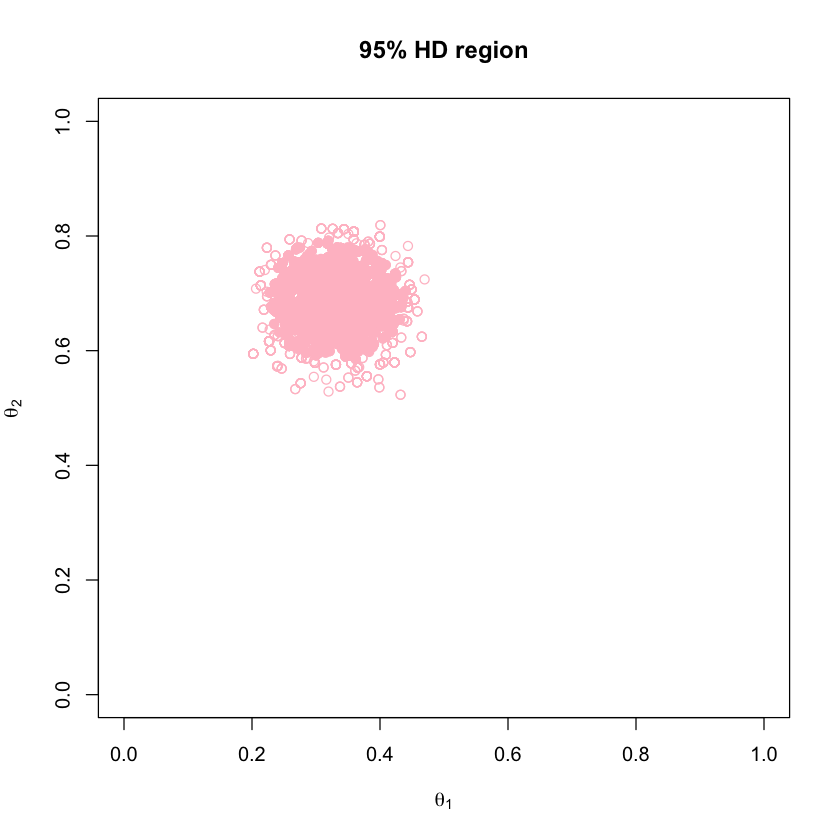

In [11]:
# Display highest density region in new graph

plot( acceptedTraj[ postProb < waterline , ] , type="p" , pch=21 , col="pink" ,
      xlim = c(0,1) , xlab = bquote(theta[1]) ,
      ylim = c(0,1) , ylab = bquote(theta[2]) ,
      main=paste(100*credmass,"% HD region",sep="") )
points( acceptedTraj[ postProb >= waterline , ] ,  pch=19 , col="pink" )
## Change next line if you want to save the graph.
want_saved_graph = FALSE # TRUE or FALSE
if ( want_saved_graph ) { saveGraph(file="BernTwoMetropolisHD",type="eps") }